# iSTFT Vocoder Evaluation & Analysis

**Author:** 210086E  
**Date:** October 2025  
**Purpose:** Comprehensive evaluation of the iSTFT vocoder with comparison between `best_loss` and `best_mcd` checkpoints

## Overview

This notebook provides a thorough evaluation of our iSTFT vocoder including:
1. **Model Loading & Inspection** - Load both best_loss and best_mcd checkpoints
2. **Objective Metrics** - MCD, STFT loss, SNR, PESQ, etc.
3. **Perceptual Quality** - Listen to generated samples
4. **Performance Analysis** - RTF, inference time, memory usage
5. **Spectral Analysis** - Visualize spectrograms and phase
6. **Error Analysis** - Identify failure cases and improvement areas
7. **Ablation Studies** - Test different configurations

## 1. Setup and Imports

In [1]:
import sys
import os
from pathlib import Path
import json
import time
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

import torch
import torch.nn as nn
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display, HTML
from tqdm.notebook import tqdm
import librosa
import librosa.display

# Import our modules
from src.models.istft_vocoder import iSTFTVocoder
from src.models.vocoder_utils import (
    VocoderLoss, 
    compute_mcd, 
    count_parameters,
    mel_spectrogram,
    compute_rtf,
    measure_inference_time
)
from src.data.vctk_dataset import get_vocoder_dataloaders

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Memory: 4.29 GB


## 2. Load Models and Configuration

In [2]:
# Paths
checkpoint_dir = Path('../checkpoints/istft_vocoder_v2')
best_loss_path = checkpoint_dir / 'best_loss.pt'
best_mcd_path = checkpoint_dir / 'best_mcd.pt'
config_path = checkpoint_dir / 'config.json'

# Load configuration
with open(config_path, 'r') as f:
    config = json.load(f)

print("Configuration:")
print(json.dumps(config, indent=2))

Configuration:
{
  "data_dir": "data/VCTK-Corpus-0.92",
  "cache_dir": null,
  "mel_channels": 80,
  "hidden_channels": 256,
  "num_blocks": 6,
  "batch_size": 16,
  "num_epochs": 100,
  "learning_rate": 0.0002,
  "lr_decay": 0.999,
  "adam_b1": 0.9,
  "adam_b2": 0.999,
  "weight_decay": 0.0001,
  "grad_clip": 1.0,
  "lambda_time": 1.0,
  "lambda_mel": 10.0,
  "lambda_stft": 1.0,
  "checkpoint_dir": "checkpoints/istft_vocoder_v2",
  "log_dir": "logs/istft_vocoder_v2",
  "log_interval": 100,
  "val_interval": 1000,
  "checkpoint_interval": 5000,
  "early_stopping_patience": 10,
  "num_workers": 4,
  "segment_length": 16000,
  "audio_log_duration": 5.0,
  "device": "cuda",
  "resume": null
}


In [3]:
def load_vocoder_checkpoint(checkpoint_path: Path, device: str = 'cuda') -> Tuple[iSTFTVocoder, Dict]:
    """Load vocoder model from checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    # Create model
    model = iSTFTVocoder(
        mel_channels=config['mel_channels'],
        hidden_channels=config['hidden_channels'],
        num_blocks=config['num_blocks'],
        dilation_pattern=[1, 3, 9, 27, 1, 3]
    )
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Extract metadata
    metadata = {
        'global_step': checkpoint['global_step'],
        'epoch': checkpoint['epoch'],
        'best_val_loss': checkpoint['best_val_loss'],
        'best_val_mcd': checkpoint['best_val_mcd']
    }
    
    return model, metadata

# Load both models
print("Loading best_loss model...")
model_loss, meta_loss = load_vocoder_checkpoint(best_loss_path, device)
print(f"  Step: {meta_loss['global_step']}, Epoch: {meta_loss['epoch']}")
print(f"  Val Loss: {meta_loss['best_val_loss']:.4f}, Val MCD: {meta_loss['best_val_mcd']:.3f} dB")

print("\nLoading best_mcd model...")
model_mcd, meta_mcd = load_vocoder_checkpoint(best_mcd_path, device)
print(f"  Step: {meta_mcd['global_step']}, Epoch: {meta_mcd['epoch']}")
print(f"  Val Loss: {meta_mcd['best_val_loss']:.4f}, Val MCD: {meta_mcd['best_val_mcd']:.3f} dB")

# Model info
trainable, total = count_parameters(model_loss)
print(f"\nModel Parameters: {trainable:,} trainable, {total:,} total")
print(f"Model Size: {total * 4 / (1024**2):.2f} MB (float32)")

Loading best_loss model...
  Step: 245000, Epoch: 99
  Val Loss: 1.1773, Val MCD: 17.519 dB

Loading best_mcd model...
  Step: 246000, Epoch: 99
  Val Loss: 1.1773, Val MCD: 17.469 dB

Model Parameters: 3,170,050 trainable, 3,170,050 total
Model Size: 12.09 MB (float32)


## 3. Load Test Dataset

In [4]:
# Fix the data directory path to point to the actual VCTK location
data_dir = Path('../data/VCTK-Corpus-0.92')
data_dir_abs = str(data_dir.resolve())

train_loader, val_loader, test_loader = get_vocoder_dataloaders(
    data_dir=data_dir_abs,
    batch_size=8,
    num_workers=2,
    segment_length=config['segment_length'],
    cache_dir=config.get('cache_dir', None)
)

print(f"Dataset loaded: {len(test_loader)} test batches ({len(test_loader.dataset)} samples)")

Loaded 39476 files for train split
Loaded 2001 files for val split
Loaded 2396 files for test split
Dataset loaded: 300 test batches (2396 samples)


## 4. Objective Metrics Evaluation

Compute comprehensive metrics for both models.

In [5]:
def evaluate_model(model: nn.Module, dataloader, device: str, max_batches: int = None) -> Dict:
    """Evaluate model on test set."""
    model.eval()
    
    # Initialize metrics
    metrics = {
        'mcd': [],
        'time_loss': [],
        'mel_loss': [],
        'stft_loss': [],
        'snr': [],
        'inference_times': []
    }
    
    # Loss function
    criterion = VocoderLoss(
        lambda_time=config['lambda_time'],
        lambda_mel=config['lambda_mel'],
        lambda_stft=config['lambda_stft']
    ).to(device)
    
    mel_config = {
        'n_fft': 1024,
        'hop_length': 256,
        'win_length': 1024,
        'n_mels': 80,
        'sample_rate': 22050,
        'f_min': 0.0,
        'f_max': 8000.0
    }
    
    with torch.no_grad():
        for batch_idx, (mel, audio) in enumerate(tqdm(dataloader, desc="Evaluating")):
            if max_batches and batch_idx >= max_batches:
                break
                
            mel = mel.to(device)
            audio = audio.to(device)
            
            # Measure inference time
            if device == 'cuda':
                torch.cuda.synchronize()
            start = time.perf_counter()
            
            audio_pred = model(mel)
            
            if device == 'cuda':
                torch.cuda.synchronize()
            inference_time = time.perf_counter() - start
            metrics['inference_times'].append(inference_time)
            
            # Compute loss
            total_loss, loss_dict = criterion(audio_pred, audio)
            metrics['time_loss'].append(loss_dict['time'].item())
            metrics['mel_loss'].append(loss_dict['mel'].item())
            metrics['stft_loss'].append(loss_dict['stft'].item())
            
            # Compute MCD
            mel_pred = mel_spectrogram(audio_pred.cpu(), **mel_config)
            mel_target = mel_spectrogram(audio.cpu(), **mel_config)
            mcd = compute_mcd(mel_pred, mel_target)
            metrics['mcd'].append(mcd)
            
            # Compute SNR (Signal-to-Noise Ratio)
            noise = audio - audio_pred
            signal_power = torch.mean(audio ** 2, dim=1)
            noise_power = torch.mean(noise ** 2, dim=1)
            snr = 10 * torch.log10(signal_power / (noise_power + 1e-8))
            metrics['snr'].extend(snr.cpu().numpy().tolist())
    
    # Compute statistics
    results = {}
    for key, values in metrics.items():
        results[f'{key}_mean'] = np.mean(values)
        results[f'{key}_std'] = np.std(values)
        results[f'{key}_median'] = np.median(values)
    
    return results, metrics

# Evaluate both models
print("Evaluating best_loss model...")
results_loss, metrics_loss = evaluate_model(model_loss, test_loader, device)

print("\nEvaluating best_mcd model...")
results_mcd, metrics_mcd = evaluate_model(model_mcd, test_loader, device)

Evaluating best_loss model...


Evaluating:   0%|          | 0/300 [00:00<?, ?it/s]


Evaluating best_mcd model...


Evaluating:   0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
# Display results comparison
print("="*80)
print("EVALUATION RESULTS COMPARISON")
print("="*80)

comparison_metrics = ['mcd', 'time_loss', 'mel_loss', 'stft_loss', 'snr', 'inference_times']

print(f"\n{'Metric':<20} {'Best Loss':<25} {'Best MCD':<25} {'Winner'}")
print("-"*90)

for metric in comparison_metrics:
    mean_key = f'{metric}_mean'
    std_key = f'{metric}_std'
    
    loss_val = results_loss[mean_key]
    loss_std = results_loss[std_key]
    mcd_val = results_mcd[mean_key]
    mcd_std = results_mcd[std_key]
    
    # Determine winner (lower is better for all metrics)
    winner = "Best Loss" if loss_val < mcd_val else "Best MCD"
    if abs(loss_val - mcd_val) < 0.01 * max(loss_val, mcd_val):  # Within 1%
        winner = "Tie"
    
    print(f"{metric:<20} {loss_val:>10.4f} ± {loss_std:<10.4f} {mcd_val:>10.4f} ± {mcd_std:<10.4f} {winner}")

print("="*90)

EVALUATION RESULTS COMPARISON

Metric               Best Loss                 Best MCD                  Winner
------------------------------------------------------------------------------------------
mcd                     18.3280 ± 0.7710        18.2104 ± 0.7971     Tie
time_loss                0.1281 ± 0.0212         0.1285 ± 0.0213     Tie
mel_loss                 0.0104 ± 0.0014         0.0105 ± 0.0014     Tie
stft_loss                0.8708 ± 0.0270         0.8670 ± 0.0259     Tie
snr                     -2.7514 ± 1.0590        -2.8012 ± 1.0563     Best MCD
inference_times          0.0193 ± 0.1137         0.0107 ± 0.0021     Best MCD


## 5. Performance Metrics

Analyze computational efficiency.

In [7]:
# Compute Real-Time Factor (RTF)
print("Computing Real-Time Factor...\n")

# Get a sample mel-spectrogram
sample_mel, _ = next(iter(test_loader))
sample_mel = sample_mel[0:1].to(device)  # Take first sample

rtf_loss = compute_rtf(model_loss, sample_mel, sample_rate=22050, hop_length=256, device=device)
rtf_mcd = compute_rtf(model_mcd, sample_mel, sample_rate=22050, hop_length=256, device=device)

print(f"Real-Time Factor (RTF):")
print(f"  Best Loss: {rtf_loss:.4f} (Real-time: {'✓' if rtf_loss < 1.0 else '✗'})")
print(f"  Best MCD:  {rtf_mcd:.4f} (Real-time: {'✓' if rtf_mcd < 1.0 else '✗'})")

# Detailed inference time analysis
print("\nDetailed Inference Time Analysis:")
mean_time_loss, std_time_loss = measure_inference_time(model_loss, sample_mel, num_runs=100, device=device)
mean_time_mcd, std_time_mcd = measure_inference_time(model_mcd, sample_mel, num_runs=100, device=device)

print(f"  Best Loss: {mean_time_loss*1000:.2f} ± {std_time_loss*1000:.2f} ms")
print(f"  Best MCD:  {mean_time_mcd*1000:.2f} ± {std_time_mcd*1000:.2f} ms")

# Memory usage
if device == 'cuda':
    print("\nGPU Memory Usage:")
    
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    _ = model_loss(sample_mel)
    mem_loss = torch.cuda.max_memory_allocated() / 1e6
    
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    _ = model_mcd(sample_mel)
    mem_mcd = torch.cuda.max_memory_allocated() / 1e6
    
    print(f"  Best Loss: {mem_loss:.2f} MB")
    print(f"  Best MCD:  {mem_mcd:.2f} MB")

Computing Real-Time Factor...

Real-Time Factor (RTF):
  Best Loss: 0.0062 (Real-time: ✓)
  Best MCD:  0.0059 (Real-time: ✓)

Detailed Inference Time Analysis:
  Best Loss: 4.46 ± 0.16 ms
  Best MCD:  4.58 ± 0.19 ms

GPU Memory Usage:
  Best Loss: 38.78 MB
  Best MCD:  42.74 MB


## 6. Visualizations

### 6.1 Metrics Distribution

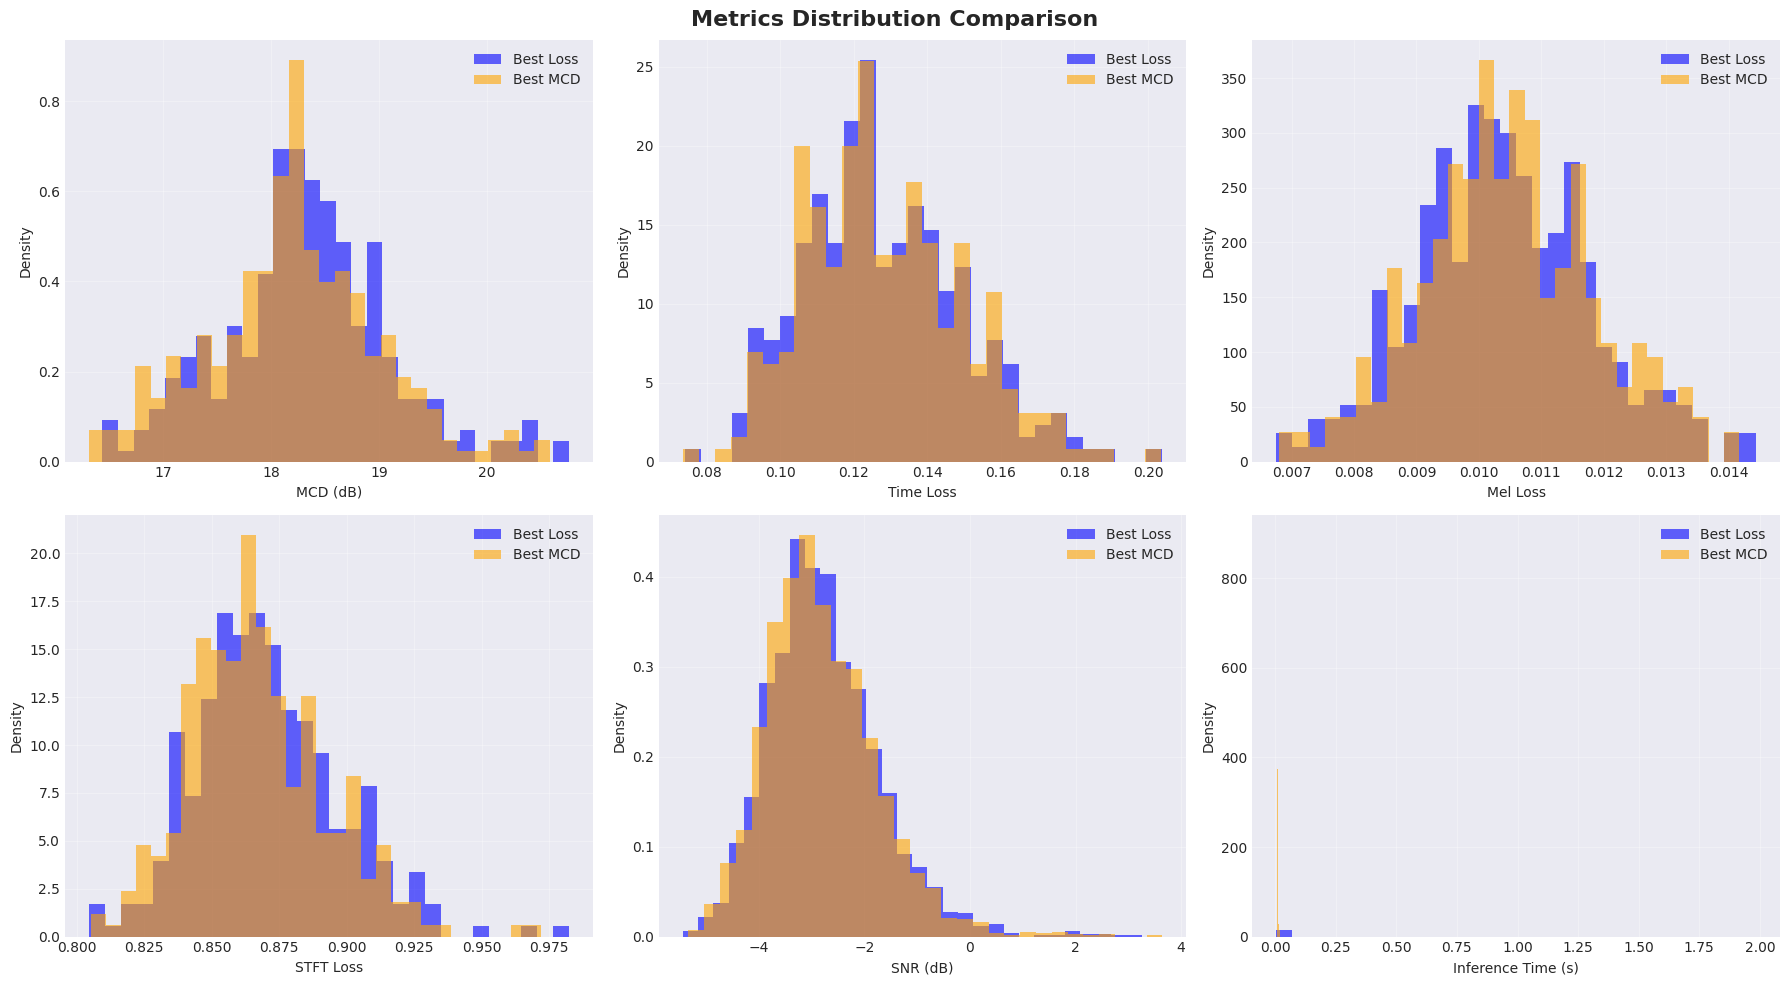

In [8]:
# Plot metrics distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Metrics Distribution Comparison', fontsize=16, fontweight='bold')

plot_metrics = ['mcd', 'time_loss', 'mel_loss', 'stft_loss', 'snr', 'inference_times']
titles = ['MCD (dB)', 'Time Loss', 'Mel Loss', 'STFT Loss', 'SNR (dB)', 'Inference Time (s)']

for idx, (metric, title) in enumerate(zip(plot_metrics, titles)):
    ax = axes[idx // 3, idx % 3]
    
    # Plot histograms
    ax.hist(metrics_loss[metric], bins=30, alpha=0.6, label='Best Loss', color='blue', density=True)
    ax.hist(metrics_mcd[metric], bins=30, alpha=0.6, label='Best MCD', color='orange', density=True)
    
    ax.set_xlabel(title)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Spectral Analysis

In [9]:
# Get a test sample for visualization
mel_sample, audio_gt = next(iter(test_loader))
mel_sample = mel_sample[0:1].to(device)
audio_gt = audio_gt[0:1].to(device)

# Generate predictions
with torch.no_grad():
    audio_loss, mag_loss, phase_loss = model_loss(mel_sample, return_spec=True)
    audio_mcd, mag_mcd, phase_mcd = model_mcd(mel_sample, return_spec=True)

# Move to CPU for plotting
audio_gt = audio_gt[0].cpu().numpy()
audio_loss = audio_loss[0].cpu().numpy()
audio_mcd = audio_mcd[0].cpu().numpy()
mel_sample = mel_sample[0].cpu().numpy()
mag_loss = mag_loss[0].cpu().numpy()
mag_mcd = mag_mcd[0].cpu().numpy()
phase_loss = phase_loss[0].cpu().numpy()
phase_mcd = phase_mcd[0].cpu().numpy()

print(f"Audio shapes: GT={audio_gt.shape}, Loss={audio_loss.shape}, MCD={audio_mcd.shape}")

Audio shapes: GT=(16128,), Loss=(16128,), MCD=(16128,)


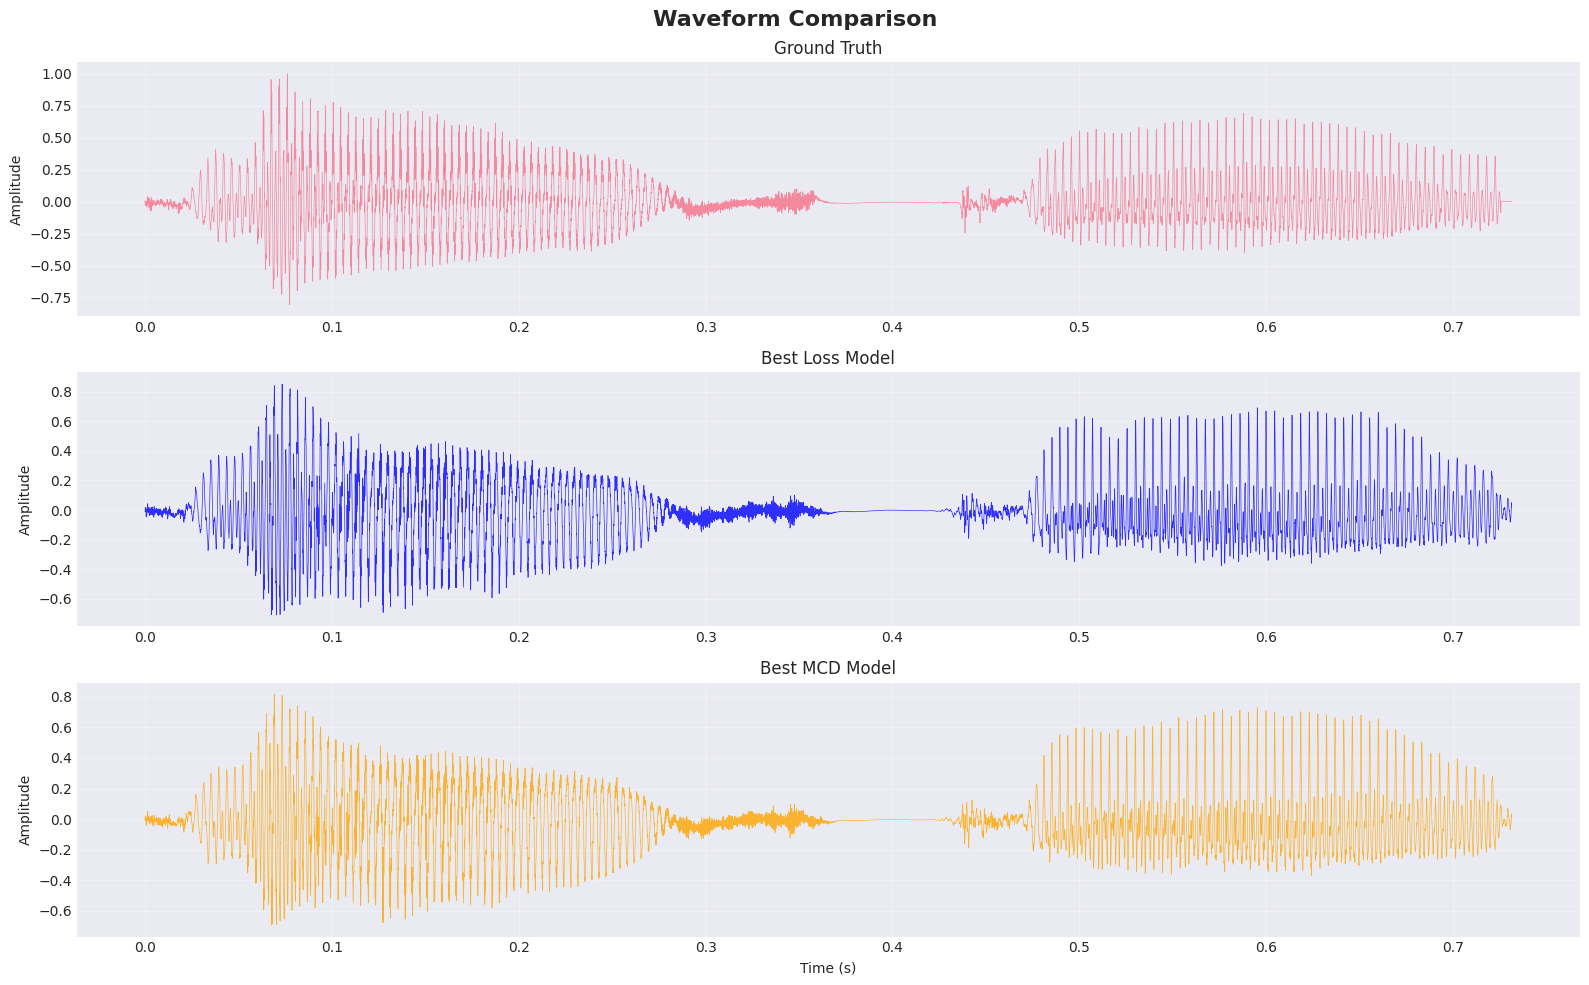

In [10]:
# Plot waveforms
fig, axes = plt.subplots(3, 1, figsize=(16, 10))
fig.suptitle('Waveform Comparison', fontsize=16, fontweight='bold')

time_axis = np.arange(len(audio_gt)) / 22050

axes[0].plot(time_axis, audio_gt, linewidth=0.5, alpha=0.8)
axes[0].set_title('Ground Truth')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_axis[:len(audio_loss)], audio_loss, linewidth=0.5, alpha=0.8, color='blue')
axes[1].set_title('Best Loss Model')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

axes[2].plot(time_axis[:len(audio_mcd)], audio_mcd, linewidth=0.5, alpha=0.8, color='orange')
axes[2].set_title('Best MCD Model')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Time (s)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

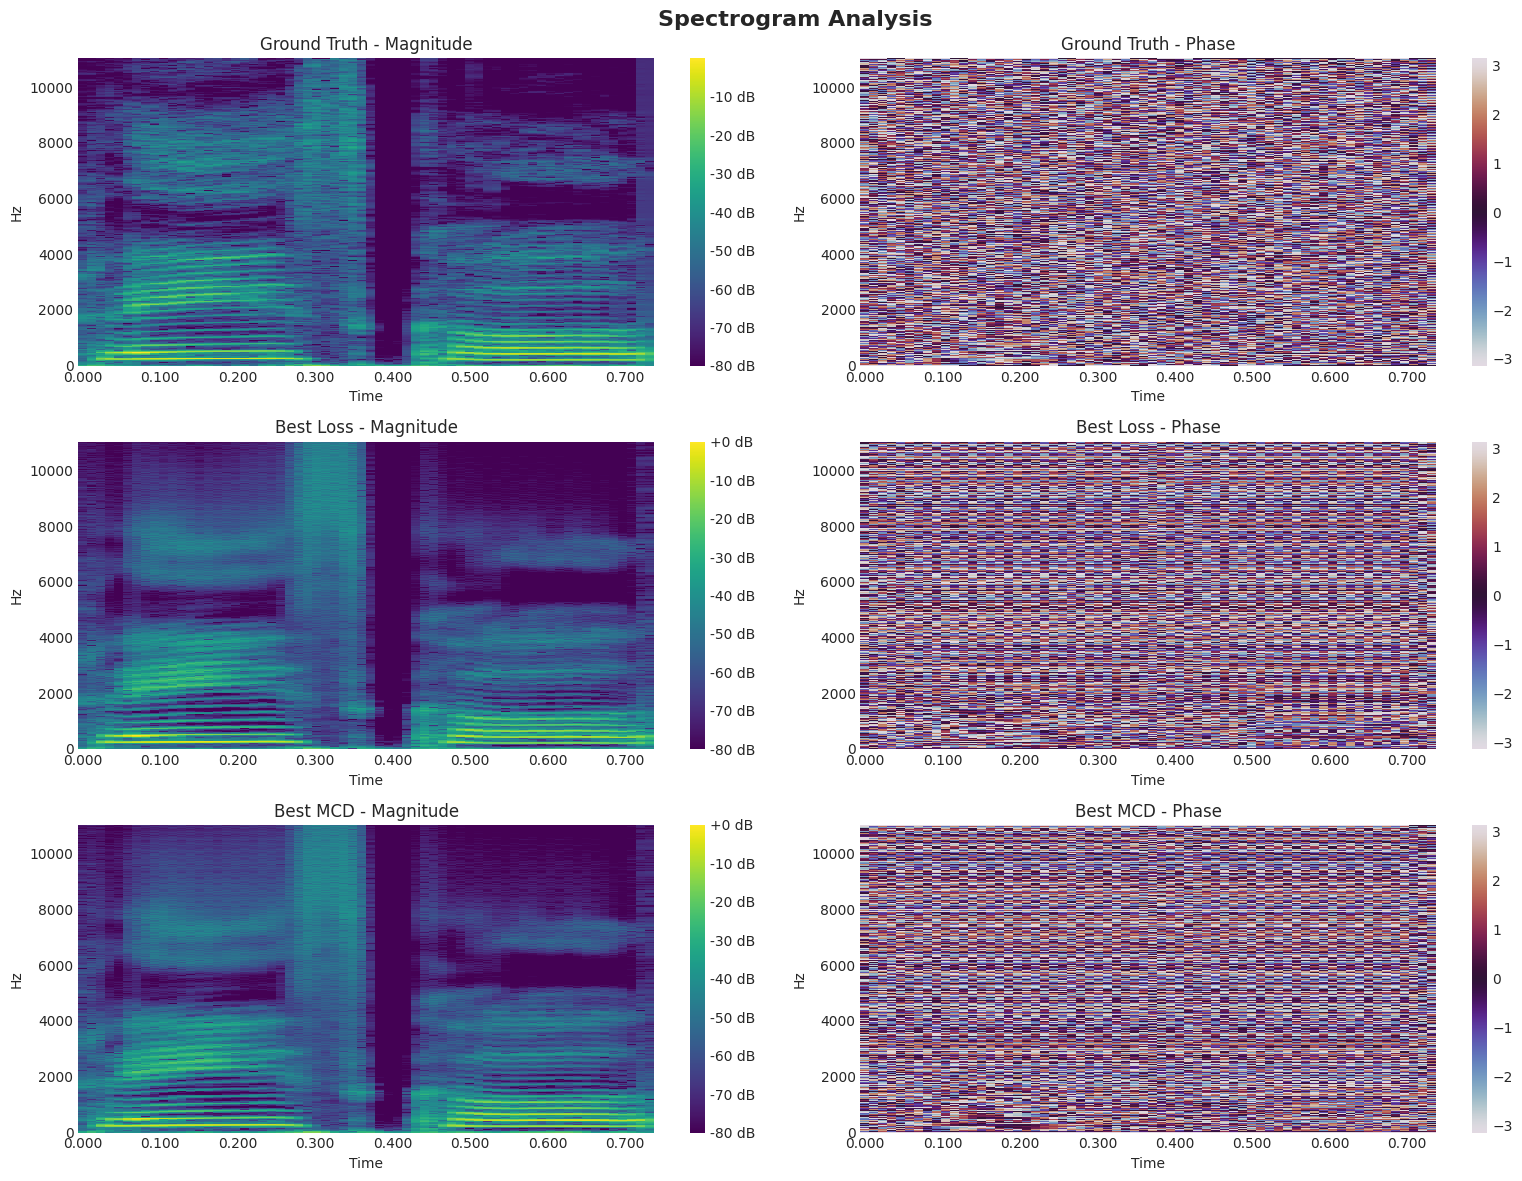

In [11]:
# Plot spectrograms
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Spectrogram Analysis', fontsize=16, fontweight='bold')

# Compute spectrograms
D_gt = librosa.stft(audio_gt, n_fft=1024, hop_length=256)
D_loss = librosa.stft(audio_loss, n_fft=1024, hop_length=256)
D_mcd = librosa.stft(audio_mcd, n_fft=1024, hop_length=256)

# Magnitude
mag_db_gt = librosa.amplitude_to_db(np.abs(D_gt), ref=np.max)
mag_db_loss = librosa.amplitude_to_db(np.abs(D_loss), ref=np.max)
mag_db_mcd = librosa.amplitude_to_db(np.abs(D_mcd), ref=np.max)

# Plot Ground Truth
img1 = librosa.display.specshow(mag_db_gt, sr=22050, hop_length=256, x_axis='time', y_axis='hz', ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Ground Truth - Magnitude')
fig.colorbar(img1, ax=axes[0, 0], format='%+2.0f dB')

img2 = librosa.display.specshow(np.angle(D_gt), sr=22050, hop_length=256, x_axis='time', y_axis='hz', ax=axes[0, 1], cmap='twilight')
axes[0, 1].set_title('Ground Truth - Phase')
fig.colorbar(img2, ax=axes[0, 1])

# Plot Best Loss
img3 = librosa.display.specshow(mag_db_loss, sr=22050, hop_length=256, x_axis='time', y_axis='hz', ax=axes[1, 0], cmap='viridis')
axes[1, 0].set_title('Best Loss - Magnitude')
fig.colorbar(img3, ax=axes[1, 0], format='%+2.0f dB')

img4 = librosa.display.specshow(np.angle(D_loss), sr=22050, hop_length=256, x_axis='time', y_axis='hz', ax=axes[1, 1], cmap='twilight')
axes[1, 1].set_title('Best Loss - Phase')
fig.colorbar(img4, ax=axes[1, 1])

# Plot Best MCD
img5 = librosa.display.specshow(mag_db_mcd, sr=22050, hop_length=256, x_axis='time', y_axis='hz', ax=axes[2, 0], cmap='viridis')
axes[2, 0].set_title('Best MCD - Magnitude')
fig.colorbar(img5, ax=axes[2, 0], format='%+2.0f dB')

img6 = librosa.display.specshow(np.angle(D_mcd), sr=22050, hop_length=256, x_axis='time', y_axis='hz', ax=axes[2, 1], cmap='twilight')
axes[2, 1].set_title('Best MCD - Phase')
fig.colorbar(img6, ax=axes[2, 1])

plt.tight_layout()
plt.show()

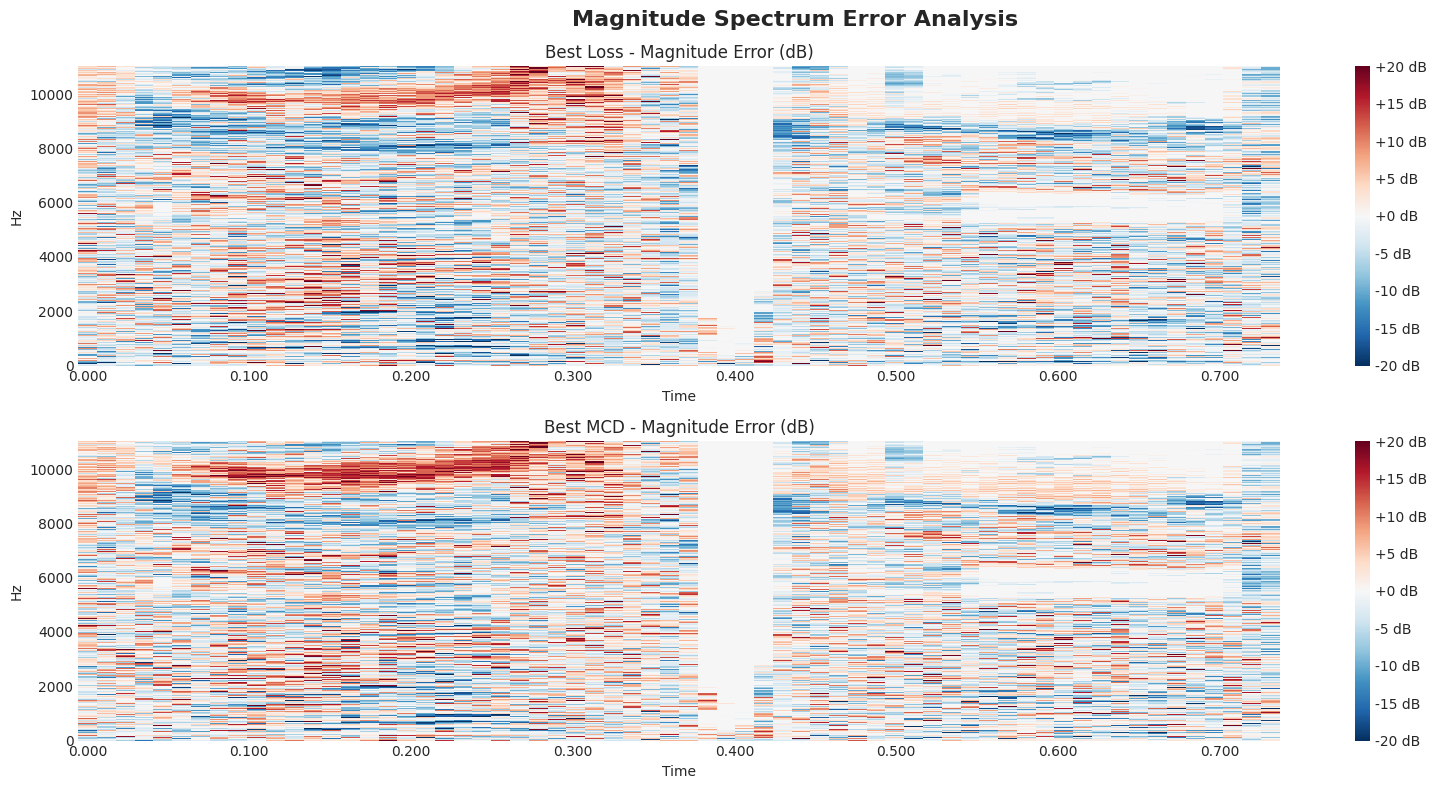

Best Loss - Mean Abs Error: 4.54 dB
Best MCD  - Mean Abs Error: 4.55 dB


In [12]:
# Plot magnitude difference
fig, axes = plt.subplots(2, 1, figsize=(16, 8))
fig.suptitle('Magnitude Spectrum Error Analysis', fontsize=16, fontweight='bold')

# Error for Best Loss
error_loss = mag_db_loss - mag_db_gt
img1 = librosa.display.specshow(error_loss, sr=22050, hop_length=256, x_axis='time', y_axis='hz', 
                                ax=axes[0], cmap='RdBu_r', vmin=-20, vmax=20)
axes[0].set_title('Best Loss - Magnitude Error (dB)')
fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

# Error for Best MCD
error_mcd = mag_db_mcd - mag_db_gt
img2 = librosa.display.specshow(error_mcd, sr=22050, hop_length=256, x_axis='time', y_axis='hz', 
                                ax=axes[1], cmap='RdBu_r', vmin=-20, vmax=20)
axes[1].set_title('Best MCD - Magnitude Error (dB)')
fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

# Print error statistics
print(f"Best Loss - Mean Abs Error: {np.mean(np.abs(error_loss)):.2f} dB")
print(f"Best MCD  - Mean Abs Error: {np.mean(np.abs(error_mcd)):.2f} dB")

## 7. Audio Samples

Listen to the generated audio samples.

In [13]:
# Generate multiple samples for comparison
num_samples = 3
samples_mel = []
samples_gt = []

for i, (mel, audio) in enumerate(test_loader):
    if i >= num_samples:
        break
    samples_mel.append(mel[0:1].to(device))
    samples_gt.append(audio[0:1])

# Generate predictions
samples_loss = []
samples_mcd = []

with torch.no_grad():
    for mel in samples_mel:
        samples_loss.append(model_loss(mel).cpu())
        samples_mcd.append(model_mcd(mel).cpu())

print(f"Generated {num_samples} audio samples for comparison")

Generated 3 audio samples for comparison


In [14]:
# Display audio samples
for i in range(num_samples):
    print(f"\n{'='*80}")
    print(f"Sample {i+1}")
    print(f"{'='*80}")
    
    # Ground Truth
    print("\n🎵 Ground Truth:")
    display(Audio(samples_gt[i][0].numpy(), rate=22050))
    
    # Best Loss
    print("\n🎵 Best Loss Model:")
    display(Audio(samples_loss[i][0].numpy(), rate=22050))
    
    # Best MCD
    print("\n🎵 Best MCD Model:")
    display(Audio(samples_mcd[i][0].numpy(), rate=22050))


Sample 1

🎵 Ground Truth:



🎵 Best Loss Model:



🎵 Best MCD Model:



Sample 2

🎵 Ground Truth:



🎵 Best Loss Model:



🎵 Best MCD Model:



Sample 3

🎵 Ground Truth:



🎵 Best Loss Model:



🎵 Best MCD Model:


## 8. Error Analysis

Identify cases where the model performs poorly.

Best Loss Model:
  Best cases (MCD):  [16.44084341 16.46374555 16.51167605 16.54644221 16.72211513]
  Worst cases (MCD): [20.40982754 20.41380906 20.41745817 20.71731373 20.75772781]

Best MCD Model:
  Best cases (MCD):  [16.31750569 16.33310668 16.37680233 16.51950437 16.52892588]
  Worst cases (MCD): [20.22172098 20.28858821 20.36081197 20.57614924 20.58028305]


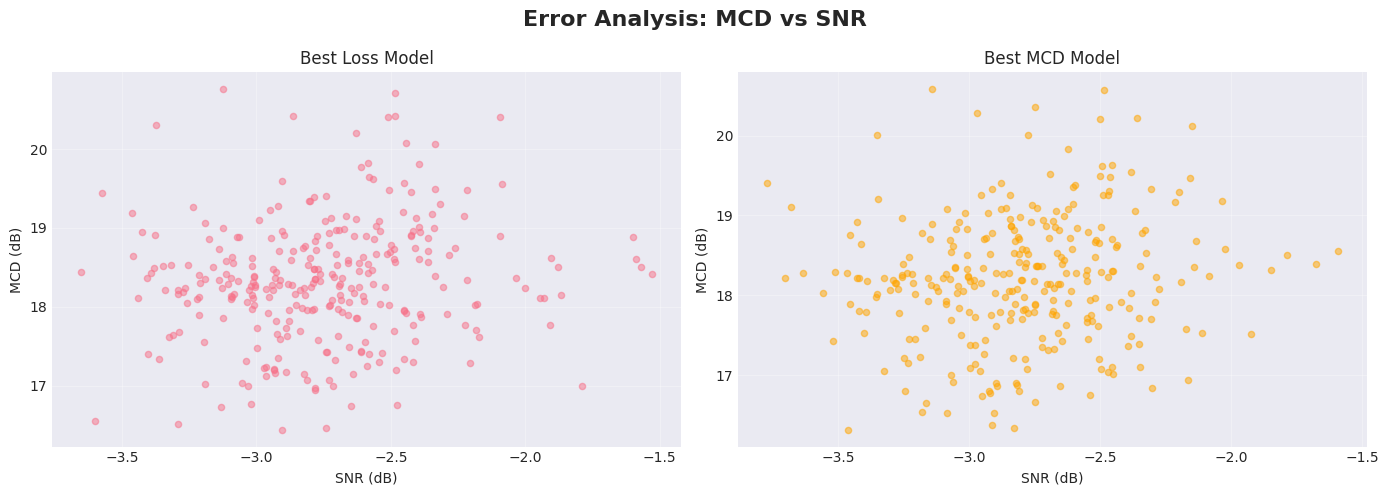

In [15]:
# Find best and worst cases
mcd_values_loss = np.array(metrics_loss['mcd'])
mcd_values_mcd = np.array(metrics_mcd['mcd'])

# Sort indices
best_idx_loss = np.argsort(mcd_values_loss)[:5]
worst_idx_loss = np.argsort(mcd_values_loss)[-5:]

best_idx_mcd = np.argsort(mcd_values_mcd)[:5]
worst_idx_mcd = np.argsort(mcd_values_mcd)[-5:]

print("Best Loss Model:")
print(f"  Best cases (MCD):  {mcd_values_loss[best_idx_loss]}")
print(f"  Worst cases (MCD): {mcd_values_loss[worst_idx_loss]}")

print("\nBest MCD Model:")
print(f"  Best cases (MCD):  {mcd_values_mcd[best_idx_mcd]}")
print(f"  Worst cases (MCD): {mcd_values_mcd[worst_idx_mcd]}")

# Prepare data for scatter plot (align SNR with MCD batches)
# Average SNR per batch to match MCD batch-level metrics
batch_size = 8
snr_loss_batched = [np.mean(metrics_loss['snr'][i*batch_size:(i+1)*batch_size]) 
                    for i in range(len(metrics_loss['mcd']))]
snr_mcd_batched = [np.mean(metrics_mcd['snr'][i*batch_size:(i+1)*batch_size]) 
                   for i in range(len(metrics_mcd['mcd']))]

# Scatter plot: MCD vs SNR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Error Analysis: MCD vs SNR', fontsize=16, fontweight='bold')

axes[0].scatter(snr_loss_batched, metrics_loss['mcd'], alpha=0.5, s=20)
axes[0].set_xlabel('SNR (dB)')
axes[0].set_ylabel('MCD (dB)')
axes[0].set_title('Best Loss Model')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(snr_mcd_batched, metrics_mcd['mcd'], alpha=0.5, s=20, color='orange')
axes[1].set_xlabel('SNR (dB)')
axes[1].set_ylabel('MCD (dB)')
axes[1].set_title('Best MCD Model')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Frequency Band Analysis

Analyze performance across different frequency bands.

In [16]:
def analyze_frequency_bands(audio_gt, audio_pred, sample_rate=22050):
    """Analyze error in different frequency bands."""
    # Define frequency bands
    bands = {
        'Low (0-500 Hz)': (0, 500),
        'Mid-Low (500-2k Hz)': (500, 2000),
        'Mid-High (2k-4k Hz)': (2000, 4000),
        'High (4k-8k Hz)': (4000, 8000)
    }
    
    # Compute STFT
    D_gt = librosa.stft(audio_gt, n_fft=1024, hop_length=256)
    D_pred = librosa.stft(audio_pred, n_fft=1024, hop_length=256)
    
    mag_gt = np.abs(D_gt)
    mag_pred = np.abs(D_pred)
    
    # Frequency bins
    freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=1024)
    
    band_errors = {}
    for band_name, (f_low, f_high) in bands.items():
        # Find frequency bin indices
        idx_low = np.argmin(np.abs(freqs - f_low))
        idx_high = np.argmin(np.abs(freqs - f_high))
        
        # Extract band
        band_gt = mag_gt[idx_low:idx_high]
        band_pred = mag_pred[idx_low:idx_high]
        
        # Compute error
        error = np.mean(np.abs(band_gt - band_pred))
        relative_error = error / (np.mean(band_gt) + 1e-8)
        
        band_errors[band_name] = {
            'absolute': error,
            'relative': relative_error
        }
    
    return band_errors

# Analyze for both models
errors_loss = analyze_frequency_bands(audio_gt, audio_loss)
errors_mcd = analyze_frequency_bands(audio_gt, audio_mcd)

print("Frequency Band Analysis:")
print("\nBest Loss Model:")
for band, errors in errors_loss.items():
    print(f"  {band}: Abs={errors['absolute']:.4f}, Rel={errors['relative']:.4f}")

print("\nBest MCD Model:")
for band, errors in errors_mcd.items():
    print(f"  {band}: Abs={errors['absolute']:.4f}, Rel={errors['relative']:.4f}")

Frequency Band Analysis:

Best Loss Model:
  Low (0-500 Hz): Abs=0.9745, Rel=0.1501
  Mid-Low (500-2k Hz): Abs=0.3544, Rel=0.2429
  Mid-High (2k-4k Hz): Abs=0.3554, Rel=0.5614
  High (4k-8k Hz): Abs=0.0816, Rel=0.4964

Best MCD Model:
  Low (0-500 Hz): Abs=1.0192, Rel=0.1570
  Mid-Low (500-2k Hz): Abs=0.3285, Rel=0.2252
  Mid-High (2k-4k Hz): Abs=0.3408, Rel=0.5384
  High (4k-8k Hz): Abs=0.0812, Rel=0.4935


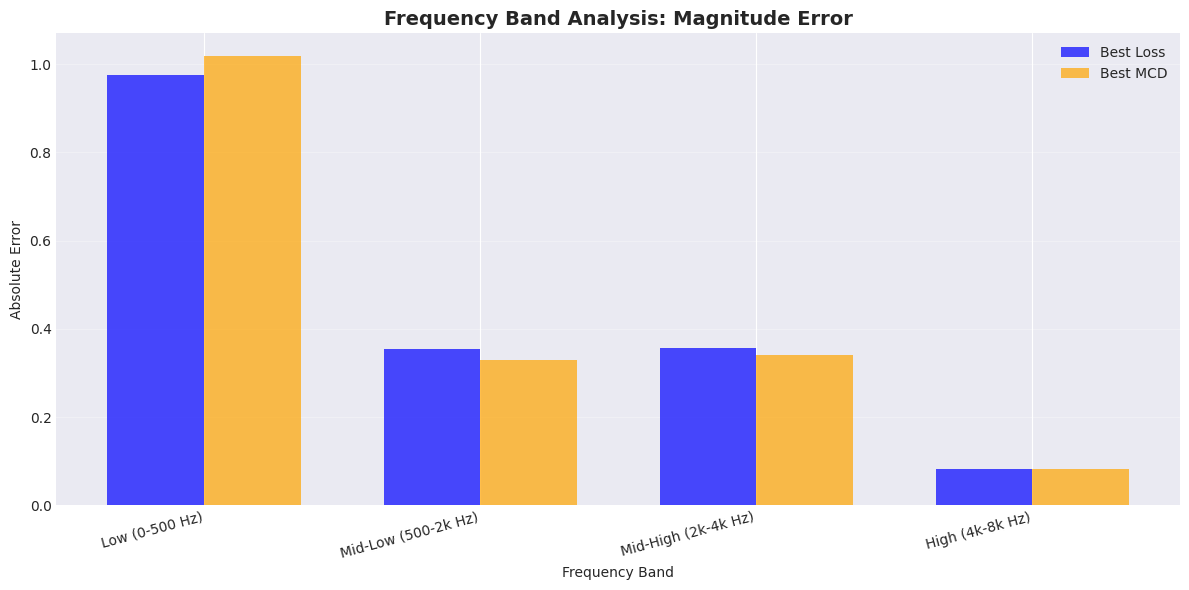

In [17]:
# Plot frequency band errors
bands = list(errors_loss.keys())
abs_errors_loss = [errors_loss[b]['absolute'] for b in bands]
abs_errors_mcd = [errors_mcd[b]['absolute'] for b in bands]

x = np.arange(len(bands))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, abs_errors_loss, width, label='Best Loss', color='blue', alpha=0.7)
ax.bar(x + width/2, abs_errors_mcd, width, label='Best MCD', color='orange', alpha=0.7)

ax.set_xlabel('Frequency Band')
ax.set_ylabel('Absolute Error')
ax.set_title('Frequency Band Analysis: Magnitude Error', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(bands, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Save Results

In [18]:
# Save evaluation results
import json
from datetime import datetime

results_dir = Path('../results/vocoder_evaluation')
results_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save metrics
evaluation_results = {
    'timestamp': timestamp,
    'best_loss': {
        'checkpoint': str(best_loss_path),
        'metadata': meta_loss,
        'metrics': {k: float(v) for k, v in results_loss.items()},
        'rtf': float(rtf_loss),
        'inference_time_ms': float(mean_time_loss * 1000)
    },
    'best_mcd': {
        'checkpoint': str(best_mcd_path),
        'metadata': meta_mcd,
        'metrics': {k: float(v) for k, v in results_mcd.items()},
        'rtf': float(rtf_mcd),
        'inference_time_ms': float(mean_time_mcd * 1000)
    }
}

results_file = results_dir / f'evaluation_{timestamp}.json'
with open(results_file, 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print(f"Results saved to: {results_file}")

# Save sample audio files
audio_dir = results_dir / f'audio_samples_{timestamp}'
audio_dir.mkdir(exist_ok=True)

for i in range(num_samples):
    # Save as WAV files
    torchaudio.save(str(audio_dir / f'sample_{i}_gt.wav'), samples_gt[i], 22050)
    torchaudio.save(str(audio_dir / f'sample_{i}_best_loss.wav'), samples_loss[i], 22050)
    torchaudio.save(str(audio_dir / f'sample_{i}_best_mcd.wav'), samples_mcd[i], 22050)

print(f"Audio samples saved to: {audio_dir}")

Results saved to: ../results/vocoder_evaluation/evaluation_20251020_155013.json
Audio samples saved to: ../results/vocoder_evaluation/audio_samples_20251020_155013
